In [42]:
!pip install bpemb
!pip install torchsummary

In [67]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Load the QA dataset

In [3]:
#Python Imports
import json
from pathlib import Path
import numpy as np
import pandas as pd
from livelossplot import PlotLosses
import nltk
import random

In [4]:
seed = 1000
random.seed(seed)
np.random.seed(seed)

In [5]:
#Path to dataset
path_dataset = Path("./Dataset/web_science_dataset.jsonl")
if not path_dataset.is_file():
    print("File path incorrect!")

In [6]:
#Load the dataset into a list
dataset_list = []
with open(path_dataset, 'r') as file:
    lines = file.readlines()
    for line in lines:
        data = json.loads(line)
        dataset_list.append(data)

In [7]:
#Convert data from list of dicts to dataframe
data_df = pd.DataFrame.from_records(dataset_list)

In [8]:
data_df.head()
print('Total number of Questions: ',data_df['question'].values.shape[0])

Total number of Questions:  1066


In [9]:
#Save the datafram to the csv
data_df.to_csv("_dataset.csv", sep='\t', encoding='utf-8')

In [69]:
#List the collumn headers
print('Collumn List:')
list(data_df.columns.values)
data_df.head()

Collumn List:


,question,questionId,questionUrl,category,categoryId,answer,answerUrl,answerId
0,Can headbanging cause brain damage?,14138,https://skeptics.stackexchange.com/questions/1...,medical-science,2,A number of injuries have been attributed to t...,https://skeptics.stackexchange.com/questions/1...,14139
1,Does the Shangri-La diet work (according to it...,10103,https://skeptics.stackexchange.com/questions/1...,nutrition,0,The Shangri-La diet depends on two theories:\n...,https://skeptics.stackexchange.com/questions/1...,16121
2,"Can phobias be genetic, but created in one gen...",18713,https://skeptics.stackexchange.com/questions/1...,psychology,4,This question has remained unanswered yet not ...,https://skeptics.stackexchange.com/questions/1...,22322
3,Do 40% of U.S. Americans think that global war...,36010,https://skeptics.stackexchange.com/questions/3...,climate-change,1,The&nbsp;40% figure most likely comes from Pew...,https://skeptics.stackexchange.com/questions/3...,36011
4,Does boiling the same water twice make it dang...,11118,https://skeptics.stackexchange.com/questions/1...,nutrition,0,The claims\n\n\nevery time the same water is b...,https://skeptics.stackexchange.com/questions/1...,11119


# Generate statistics on the Dataset

In [65]:
#Compute data statistics
def get_stats(x, Type):
    sentence_length = [len(sentence.split(' ')) for sentence in x]
    avg_length = np.mean(sentence_length)
    std = np.std(sentence_length)
    return {Type + "_mean":avg_length, Type + "_std":std}

#Group data {Questions and Answers} by category
grouped = data_df.groupby(['categoryId'])

data_stats = []
#Iterate over the groups
for category,group in grouped:
    
    #Extract questions and answers
    question_list = group['question'].values
    answer_list = group['answer'].values
    category_lbl = list(set(group['category'].values))
    
    #Get question and answer stats
    row_dict = {}
    row_dict['Category'] = category_lbl[0]
    row_dict['ID'] = category
    row_dict.update(get_stats(question_list, "Question"))
    row_dict.update(get_stats(answer_list, "Answer"))
    
    
    
    #Save the stats
    data_stats.append(row_dict)

#Compute the statistics matrix
df_statistics = pd.DataFrame.from_records(data_stats)
print(df_statistics.head())

          Category  ID  Question_mean  Question_std  Answer_mean  Answer_std
0        nutrition   0       9.277778      3.498717   338.666667  378.635082
1   climate-change   1      11.218750      3.805706   423.593750  328.899287
2  medical-science   2       9.030120      3.164991   428.373494  406.564173
3          physics   3       9.946237      3.424659   338.935484  382.001979
4       psychology   4       9.252252      3.570319   413.932432  360.163902


## Question Category classification: Naive Bayes, Random Forest

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
#Retrieve all questions
ques_list = data_df['question'].values
ques_id = data_df['categoryId'].values

# Split dataset
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
ss.get_n_splits(ques_list, ques_id)

X_train = y_train = y_test = X_test = None
for train_index, test_index in ss.split(ques_list, ques_id):
    X_train, X_test = ques_list[train_index], ques_list[test_index]
    y_train, y_test = ques_id[train_index], ques_id[test_index]

In [14]:
#Using the Vectorizer, convert the data into numeric vectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text

# Stop words
stop_words = text.ENGLISH_STOP_WORDS

# Tokenizer
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        if item not in stop_words:
            stems.append(PorterStemmer().stem(item))
    return stems

# Vectorizer
vectorizer = CountVectorizer(tokenizer = tokenize)

#Apply the vectorizer on the question list
question_vectors = vectorizer.fit_transform(X_train)
_test_question_vectors = vectorizer.transform(X_test)

In [15]:
#Now, we apply the Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# classifier
clf = MultinomialNB()
    
# Train the model
clf.fit(question_vectors, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf_forest = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf_forest.fit(question_vectors, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [41]:
from sklearn.metrics import classification_report
#Measure the accuracy
print('Naive Bayes',classification_report(clf.predict(_test_question_vectors), y_test))
print('Random Forest', classification_report(clf_forest.predict(_test_question_vectors), y_test))


Naive Bayes               precision    recall  f1-score   support

           0       0.95      0.62      0.75       123
           1       0.74      0.88      0.80        16
           2       0.24      0.89      0.38         9
           3       0.59      0.76      0.67        29
           4       0.67      0.81      0.73        37

    accuracy                           0.70       214
   macro avg       0.64      0.79      0.67       214
weighted avg       0.81      0.70      0.72       214

Random Forest               precision    recall  f1-score   support

           0       0.85      0.52      0.64       131
           1       0.68      0.87      0.76        15
           2       0.18      0.55      0.27        11
           3       0.35      0.68      0.46        19
           4       0.51      0.61      0.55        38

    accuracy                           0.57       214
   macro avg       0.52      0.64      0.54       214
weighted avg       0.70      0.57      0.60       2

# Question Category classification: BiLSTM

In [48]:
#Create a Dataloader class
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import csv
import gzip

In [49]:
import torch
import random
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from typing import List, Tuple

## Set all Random Seeds.
This ensures the results are deterministic.

In [50]:
# Seeds
seed = 1000
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Define some globals
batch_size = 10
lstm_dim = 50
emb_vs_size = 25000
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Prepare the dataset

In [51]:
def text_to_batch_bilstm(text, tokenizer):
    
    # Tokenise and encode using the Byte-Pair word embeddings
    input_ids = [tokenizer.encode_ids_with_eos(t) for t in text]
    return input_ids, [len(ids) for ids in input_ids]

def collate_batch_bilstm(input_data):
    input_ids = [i[0][0] for i in input_data]
    seq_lens = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [emb_vs_size] * (max_length - len(i))) for i in input_ids]

    assert (all(len(i) == max_length for i in input_ids))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

class SentenceDataset(Dataset):
    
    """ Load the Sentence Dataset """
    def __init__(self, input_df, tokenizer):
        
        #Retrieve all questions and labels
        self.questions = input_df['question'].values
        self.labels = input_df['categoryId'].values
        
        #Store the dataset length
        self.len = len(self.labels)
        self.tokenizer = tokenizer
    
    def __getitem__(self, index):
        
        # Select the corresponding index
        question = self.questions[index]
        label = self.labels[index]
        
        # Tokenise the question text
        input_ids, seq_lens = text_to_batch_bilstm([question], self.tokenizer)
        return input_ids, seq_lens, self.labels[index]
    
    def __len__(self):
        return self.len

In [52]:
# Load the word embeddings
from bpemb import BPEmb
bpemb_en = BPEmb(lang='en', dim=300, vs=emb_vs_size)

#Add 0 embedding for padding
pretrained_embeddings = np.concatenate([bpemb_en.emb.vectors, np.zeros(shape=(1,300))], axis=0)
vocabulary = bpemb_en.emb.index2word + ['[PAD]']

In [53]:
# Split the data
train_df, test_df = train_test_split(data_df, stratify=data_df['categoryId'].values, test_size=0.2)
test_df, val_df = train_test_split(test_df, stratify=test_df['categoryId'].values, test_size=0.5)

In [54]:
train_df

,question,questionId,questionUrl,category,categoryId,answer,answerUrl,answerId
667,Is smoking weed bad for your health?,487,https://skeptics.stackexchange.com/questions/487,medical-science,2,I’m bothered with the ‘you smoke cigarettes an...,https://skeptics.stackexchange.com/questions/4...,5567
169,Is tequila a probiotic?,35736,https://skeptics.stackexchange.com/questions/3...,nutrition,0,The Facebook video is wrong because they have ...,https://skeptics.stackexchange.com/questions/3...,36811
510,Can those limited to the left side of their br...,14026,https://skeptics.stackexchange.com/questions/1...,psychology,4,\n Can those limited to the left side of thei...,https://skeptics.stackexchange.com/questions/1...,14039
849,"Is the ""Back to the future"" Huvr board real?",19776,https://skeptics.stackexchange.com/questions/1...,physics,3,"Looking at their own website, the product they...",https://skeptics.stackexchange.com/questions/1...,19779
222,Is a woman who dresses sexually suggestively m...,3028,https://skeptics.stackexchange.com/questions/3028,psychology,4,This is a touchy issue. I think it is importan...,https://skeptics.stackexchange.com/questions/3...,7644
...,...,...,...,...,...,...,...,...
874,Is the Rorschach test a reliable diagnostic to...,7424,https://skeptics.stackexchange.com/questions/7424,psychology,4,This seems to be one of our questions which ha...,https://skeptics.stackexchange.com/questions/7...,8632
121,Can Sunny D turn you yellow?,4153,https://skeptics.stackexchange.com/questions/4153,nutrition,0,High doses of beta-carotene can be deposited i...,https://skeptics.stackexchange.com/questions/4...,4155
814,Do cats always land on their feet?,3060,https://skeptics.stackexchange.com/questions/3060,physics,3,No. Unless...\n\n\nThe cat is healthy and more...,https://skeptics.stackexchange.com/questions/3...,3063
75,Does wetting a beer glass change the foam char...,44984,https://skeptics.stackexchange.com/questions/4...,physics,3,"In 1953, a paper looking at some of the factor...",https://skeptics.stackexchange.com/questions/4...,44985


In [64]:
# Load the train_dataset
train_dataset = SentenceDataset(train_df, bpemb_en)
train_dl = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True, collate_fn=collate_batch_bilstm)

# Load the validation_dataset
val_dataset = SentenceDataset(val_df, bpemb_en)
valid_dl = DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=True, collate_fn=collate_batch_bilstm)

# Load the testing dataset
test_dataset = SentenceDataset(test_df, bpemb_en)
test_dl = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True, collate_fn=collate_batch_bilstm)

# Create LSTM Model

In [61]:
class LSTM_Model(torch.nn.Module):
    
    def __init__(self, pretrained_embeddings: torch.tensor,
                n_classes: int,
                lstm_dim: int,
                dropout_prob: float = 0.1,
                n_stack_lstm: int = 2):
        
        super(LSTM_Model, self).__init__()
        
        # Define Model layers
        ## Embedding layer
        self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx = pretrained_embeddings.shape[0]-1)
        
        ## BiLSTM layer
        self.bilstm_layer = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, n_stack_lstm, batch_first = True, dropout = dropout_prob, bidirectional = True)
        
        ## Dense layer, 2 * lstm_dim -> because BiLSTM
        self.dense_layer = nn.Linear(2 * lstm_dim, n_classes)
        
        # Initialize weights
        parameter_list = list(self.bilstm_layer.named_parameters()) + list(self.dense_layer.named_parameters())
        for name,param in parameter_list:
            if name in ['bias']:
                nn.init.zeros_(param)
            elif name in ['weight']:
                nn.init.xavier_normal_(param)
        
        # Save class size
        self.n_classes = n_classes
        
    
    def forward(self, inputs, input_seq_length, labels):
        
        # Encode input using the embedding layer
        embedding = self.embedding_layer(inputs)
        
        # Pack padded: return PackedSequence object
        lstm_in = nn.utils.rnn.pack_padded_sequence(embedding, input_seq_length, batch_first = True, enforce_sorted = False)
        
        # BiLSTM_input: Packed Sequence object
        lstm_out, hidden = self.bilstm_layer(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first = True)
        
        # Extract the final state of all variable length inputs
        ff_in = lstm_out.gather(1, input_seq_length.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        # Get logits (b x 2)
        logits = self.dense_layer(ff_in).view(-1, self.n_classes)
        outputs = (logits,)
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            outputs = (loss,) + outputs

        return outputs

In [63]:
# Create the model
model = LSTM_Model(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings),
    n_classes=len(set(data_df['categoryId'].values)),
    lstm_dim=lstm_dim, 
    dropout_prob=0.2)

# Use GPU for model training (or) use model.to(device)
#model.cuda()
model.to(device)

# Set optimizer algorithm
n_epochs = 150
lr = 5e-4
optimizer = Adam(model.parameters(), lr=lr)

In [276]:
# Compute model accuracy
def accuracy(logits, labels):
  return torch.sum(torch.argmax(logits, dim=-1) == labels).type(torch.float) / float(labels.shape[0])

# Test model performance on test-data
def test_model(model = model, test_dl = test_dl, device = device):
  model.eval()
  with torch.no_grad():    
    for batch in test_dl:
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]
        
      _test_loss, logits = model(input_ids, seq_lens, labels=labels)
      acc = accuracy(logits, labels)
        
      print(f'Testing accuracy: {acc}','test_loss:',_test_loss.item())
    
# Train model
def train(model = model, train_dl = train_dl, valid_dl = valid_dl, optimizer = optimizer, n_epochs = n_epochs, device = device):
    
  liveloss = PlotLosses()

  # Initialize loss and accuracy 
  losses = []
  best_loss = None
  best_model = None
    
  for ep in range(n_epochs):
    
    # Store training logs
    logs = {}
    
    print('Epoch:',ep)
    
    # Loss per epoch
    loss_epoch = []
    
    for batch in tqdm(train_dl):  
        
      # Train model
      model.train()
      optimizer.zero_grad()
      
      # Get data from batch
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]
      
      # Compute output and loss
      loss, logits = model(input_ids, seq_lens, labels=labels)
        
      # Append per-epoch loss
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Backpropogate loss
      loss.backward()
      optimizer.step()
    
    # Evaluate after epoch
    model.eval()
    
    with torch.no_grad():
      for batch in valid_dl:
        
        batch = tuple(t.to(device) for t in batch)
        input_ids = batch[0]
        seq_lens = batch[1]
        labels = batch[2]

        _val_loss, logits = model(input_ids, seq_lens, labels=labels)
        acc = accuracy(logits, labels)
        
        # Print model performance stats
        print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}', '\nVal_loss:',_val_loss.item(),'\n\n')        
        
        # Save the model with lowest validation loss
        if best_loss is None:
            best_loss = _val_loss.item()
            best_model = model.state_dict()
            
        elif _val_loss.item() < best_loss:
            best_loss = _val_loss.item()
            best_model = model.state_dict()
            
        # Save logs for plotting
        logs['Train-loss'] = sum(loss_epoch) / len(loss_epoch)
        logs['Validation-loss'] = _val_loss.item()
    
    liveloss.update(logs)
    liveloss.draw()

  model.load_state_dict(best_model)
  return best_model

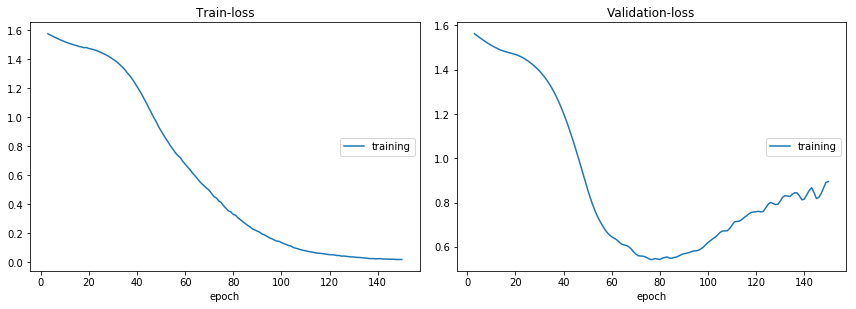

Train-loss:
training   (min:    0.016, max:    1.592, cur:    0.016)

Validation-loss:
training   (min:    0.543, max:    1.579, cur:    0.895)


In [272]:
best_validation_model = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

In [277]:
model.load_state_dict(best_validation_model)
test_model()

# Save model
state = {
    'epoch': n_epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

torch.save(state, './models/77_5_topic_classifier_best.model')

Testing accuracy: 0.7757009267807007 test_loss: 1.0268534421920776


In [72]:
# Visualize Question text
import json
import pandas as pd
import numpy as np
import string
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Stop words
stop_words = text.ENGLISH_STOP_WORDS

# Tokenizer
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        if item not in stop_words:
            stems.append(PorterStemmer().stem(item))
    return stems

# TF-IDF
vectorizer = TfidfVectorizer(tokenizer = tokenize)

# Get questions
questions_list = list(data_df['question'].values)
questions_lbl = list(data_df['category'].values)

vectors = vectorizer.fit_transform(questions_list)

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=50, verbose=2).fit_transform(X_reduced)

print(X_embedded.shape)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1066 samples in 0.004s...
[t-SNE] Computed neighbors for 1066 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1066
[t-SNE] Computed conditional probabilities for sample 1066 / 1066
[t-SNE] Mean sigma: 0.111473
[t-SNE] Computed conditional probabilities in 0.075s
[t-SNE] Iteration 50: error = 70.1974487, gradient norm = 0.2663717 (50 iterations in 0.758s)
[t-SNE] Iteration 100: error = 72.3385544, gradient norm = 0.2380399 (50 iterations in 0.717s)
[t-SNE] Iteration 150: error = 73.0104828, gradient norm = 0.2325916 (50 iterations in 0.743s)
[t-SNE] Iteration 200: error = 72.7456970, gradient norm = 0.2369364 (50 iterations in 0.732s)
[t-SNE] Iteration 250: error = 71.7786636, gradient norm = 0.2470315 (50 iterations in 0.709s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.778664
[t-SNE] Iteration 300: error = 1.1373850, gradient norm = 0.0013964 (50 iterations in 0.528s

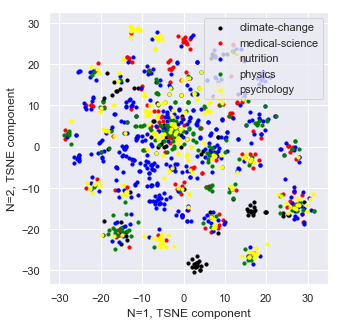

In [99]:
import numpy as np
from matplotlib import pyplot as plt

scatter_x = np.array([1,2,3,4,5])
scatter_y = np.array([5,4,3,2,1])
group = np.array(questions_lbl)
cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4:'yellow'}
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlabel("N=1, TSNE component")
ax.set_ylabel("N=2, TSNE component")

cid = 0
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[cid], label = g, s = 10)
    cid += 1
ax.legend(loc = 'best')

plt.savefig('tsne_plt.jpg')
plt.show()